<a href="https://colab.research.google.com/github/RealB1ackY/ISnT_Lab5-6/blob/main/PR3_SVM_VIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install apriori_python efficient-apriori fpgrowth_py pyarmviz numpy pandas matplotlib seaborn  scikit-learn matplotlib umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 658 kB 4.8 MB/s 
     |████████████████████████████████| 88 kB 6.7 MB/s 
     |████████████████████████████████| 1.1 MB 55.8 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=fdde2af19d44ab474dbb4c3ae2788a387adf453e073cd04aa7fd785ee42dc8ed
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55512 sha256=2e9faf47845a03547eba835a99998d9ed6be7c777bb30859a51491a9084aa720
  Stored in directory: /root/.cache/pip/wheels/19/bc/eb/974072a56a7082a302f8b4be1ad6d21bf5019235c2eff65928
Successfully built umap-learn pynndescent


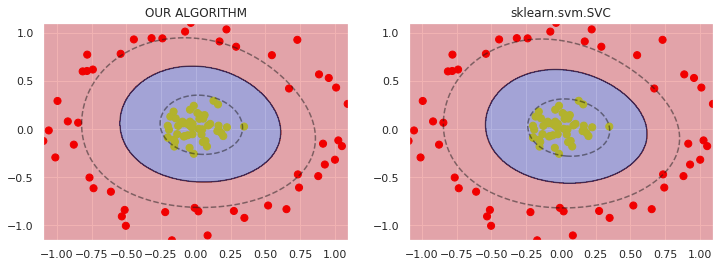

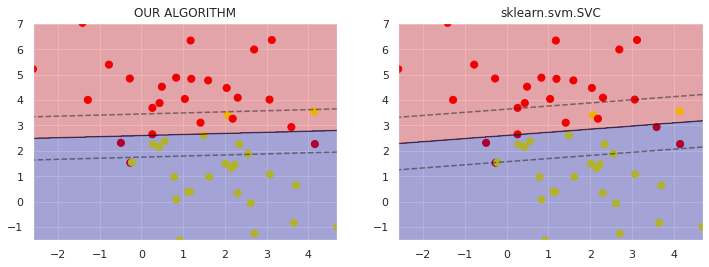

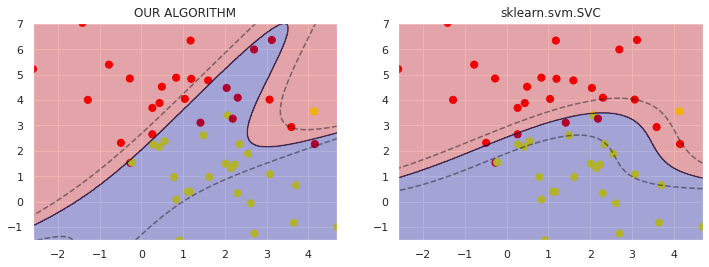

In [ ]:
import numpy as np


class SVM:
  def __init__(self, kernel='linear', C=10000.0, max_iter=100000, degree=3, gamma=1):
    self.kernel = {'poly'  : lambda x,y: np.dot(x, y.T)**degree,
         'rbf': lambda x,y: np.exp(-gamma*np.sum((y-x[:,np.newaxis])**2,axis=-1)),
         'linear': lambda x,y: np.dot(x, y.T)}[kernel]
    self.C = C
    self.max_iter = max_iter

  # ограничение параметра t, чтобы новые лямбды не покидали границ квадрата
  def restrict_to_square(self, t, v0, u): 
    t = (np.clip(v0 + t*u, 0, self.C) - v0)[1]/u[1]
    return (np.clip(v0 + t*u, 0, self.C) - v0)[0]/u[0]

  def fit(self, X, y):
    self.X = X.copy()
    # преобразование классов 0,1 в -1,+1; для лучшей совместимости с sklearn
    self.y = y * 2 - 1 
    self.lambdas = np.zeros_like(self.y, dtype=float)
    # формула (3)
    self.K = self.kernel(self.X, self.X) * self.y[:,np.newaxis] * self.y
    
    # выполняем self.max_iter итераций
    for _ in range(self.max_iter):
      # проходим по всем лямбда 
      for idxM in range(len(self.lambdas)):                                    
        # idxL выбираем случайно
        idxL = np.random.randint(0, len(self.lambdas))                         
        # формула (4с)
        Q = self.K[[[idxM, idxM], [idxL, idxL]], [[idxM, idxL], [idxM, idxL]]] 
        # формула (4a)
        v0 = self.lambdas[[idxM, idxL]]                                        
        # формула (4b)
        k0 = 1 - np.sum(self.lambdas * self.K[[idxM, idxL]], axis=1)           
        # формула (4d)
        u = np.array([-self.y[idxL], self.y[idxM]])                            
        # регуляризированная формула (5), регуляризация только для idxM = idxL
        t_max = np.dot(k0, u) / (np.dot(np.dot(Q, u), u) + 1E-15) 
        self.lambdas[[idxM, idxL]] = v0 + u * self.restrict_to_square(t_max, v0, u)
    
    # найти индексы опорных векторов
    idx, = np.nonzero(self.lambdas > 1E-15) 
    # формула (1)
    self.b = np.mean((1.0-np.sum(self.K[idx]*self.lambdas, axis=1))*self.y[idx]) 
  
  def decision_function(self, X):
    return np.sum(self.kernel(X, self.X) * self.y * self.lambdas, axis=1) + self.b

  def predict(self, X): 
    # преобразование классов -1,+1 в 0,1; для лучшей совместимости с sklearn
    return (np.sign(self.decision_function(X)) + 1) // 2


from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.datasets import make_blobs, make_circles
from matplotlib.colors import ListedColormap

def test_plot(X, y, svm_model, axes, title):
  plt.axes(axes)
  xlim = [np.min(X[:, 0]), np.max(X[:, 0])]
  ylim = [np.min(X[:, 1]), np.max(X[:, 1])]
  xx, yy = np.meshgrid(np.linspace(*xlim, num=700), np.linspace(*ylim, num=700))
  rgb=np.array([[210, 0, 0], [0, 0, 150]])/255.0
  
  svm_model.fit(X, y)
  z_model = svm_model.decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
  
  plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
  plt.contour(xx, yy, z_model, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
  plt.contourf(xx, yy, np.sign(z_model.reshape(xx.shape)), alpha=0.3, levels=2, cmap=ListedColormap(rgb), zorder=1)
  plt.title(title)

X, y = make_circles(100, factor=.1, noise=.1)
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
test_plot(X, y, SVM(kernel='rbf', C=10, max_iter=60, gamma=1), axs[0], 'OUR ALGORITHM')
test_plot(X, y, SVC(kernel='rbf', C=10, gamma=1), axs[1], 'sklearn.svm.SVC')

X, y = make_blobs(n_samples=50, centers=2, random_state=0, cluster_std=1.4)
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
test_plot(X, y, SVM(kernel='linear', C=10, max_iter=60), axs[0], 'OUR ALGORITHM')
test_plot(X, y, SVC(kernel='linear', C=10), axs[1], 'sklearn.svm.SVC')

fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
test_plot(X, y, SVM(kernel='poly', C=5, max_iter=60, degree=3), axs[0], 'OUR ALGORITHM')
test_plot(X, y, SVC(kernel='poly', C=5, degree=3), axs[1], 'sklearn.svm.SVC')

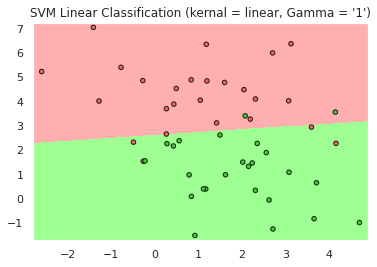

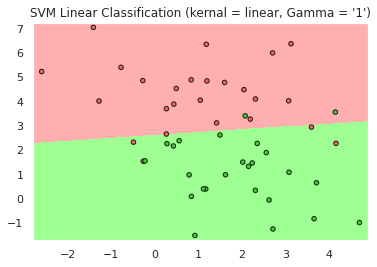

In [ ]:
cm_dark = ListedColormap(['#ff6060', '#8282ff','#ffaa00','#fff244','#4df9b9','#76e8fc','#3ad628'])
cm_bright = ListedColormap(['#ffafaf', '#c6c6ff','#ffaa00','#ffe2a8','#bfffe7','#c9f7ff','#9eff93'])

h = .02  # step size in the mesh
C_param = 1 # No of neighbours
for weights in ['uniform', 'distance']:
    # we create an instance of Neighbours Classifier and fit the data.
    clf1 = SVC(kernel='linear',C=C_param)
    clf1.fit(X, y)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min()-.20, X[:, 0].max()+.20
    y_min, y_max = X[:, 1].min()-.20, X[:, 1].max()+.20
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf1.predict(np.c_[xx.ravel(), yy.ravel()])   # ravel to flatten the into 1D and c_ to concatenate 

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cm_bright)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_dark,
                edgecolor='k', s=20)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("SVM Linear Classification (kernal = linear, Gamma = '%s')"% (C_param))

plt.show()

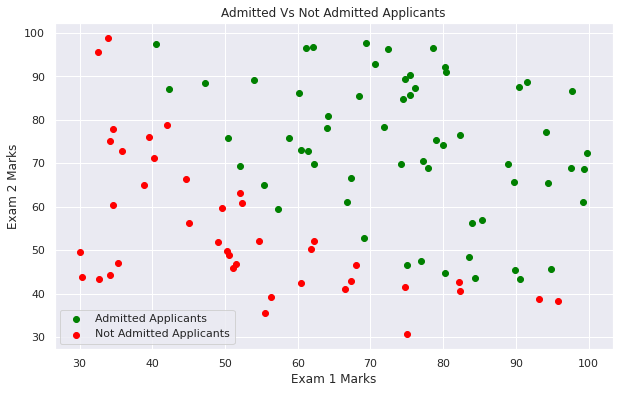

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn import svm
import umap
from sklearn.preprocessing import StandardScaler
import warnings

warnings.filterwarnings('ignore')

df = pd.read_csv('https://raw.githubusercontent.com/satishgunjal/datasets/master/admission_basedon_exam_scores.csv')

df_admitted = df[df['Admission status'] == 1]
# print('Training examples with admission status 1 are = ', df_admitted.shape[0])
# df_admitted.head(3)

df_notadmitted = df[df['Admission status'] == 0]
# print('Training examples with admission status 0 are = ', df_notadmitted.shape[0])
# df_notadmitted.head(3)


def plot_data(title):    
    plt.figure(figsize=(10,6))
    plt.scatter(df_admitted['Exam 1 marks'], df_admitted['Exam 2 marks'], color= 'green', label= 'Admitted Applicants')
    plt.scatter(df_notadmitted['Exam 1 marks'], df_notadmitted['Exam 2 marks'], color= 'red', label= 'Not Admitted Applicants')
    plt.xlabel('Exam 1 Marks')
    plt.ylabel('Exam 2 Marks')
    plt.title(title)
    plt.legend()
 
plot_data(title = 'Admitted Vs Not Admitted Applicants')
# df = pd.read_csv("dataset/glass.csv")
# df = df[:146]
# print('Shape of data= ', df.shape)
# # df.head()

# df_class_1 = df[df['classes'] == 1]
# print('Training examples with classes status 1 are = ', df_class_1.shape[0])
# df_class_1.head(3)

# df_class_2 = df[df['classes'] == 2]
# print('Training examples with classes status 2 are = ', df_class_2.shape[0])
# df_class_2.head(3)

# df_admitted_3 = df[df['classes'] == 3]
# print('Training examples with classes status 3 are = ', df_admitted_3.shape[0])
# df_admitted_3.head(3)

# df_admitted_5 = df[df['classes'] == 5]
# print('Training examples with classes status 5 are = ', df_admitted_5.shape[0])
# df_admitted_5.head(3)

# df_admitted_6 = df[df['classes'] == 6]
# print('Training examples with classes status 6 are = ', df_admitted_6.shape[0])
# df_admitted_6.head(3)

# df_admitted_7 = df[df['classes'] == 7]
# print('Training examples with classes status 7 are = ', df_admitted_7.shape[0])
# df_admitted_1.head(3)


# def plot_data(title):    
#     plt.figure(figsize=(10,6))
#     plt.scatter(df_class_1['Ca'], df_class_1['Na'], color= 'green', label= 'Class <1>')
#     plt.scatter(df_class_2['Na'], df_class_2['Ca'], color= 'red', label= 'Class <2>')
# #     plt.scatter(df_admitted_3['id'], df_admitted_3['Al'], color= 'blue', label= 'Class <3>')
# #     plt.scatter(df_admitted_5['id'], df_admitted_5['Fe'], color= 'yellow', label= 'Class <5>')
# #     plt.scatter(df_admitted_6['id'], df_admitted_6['Ca'], color= 'maroon', label= 'Class <6>')
# #     plt.scatter(df_admitted_7['id'], df_admitted_7['Ba'], color= 'black', label= 'Class <7>')
#     plt.xlabel('Ca')
#     plt.ylabel('Na')
#     plt.title(title)
#     plt.legend()



# df_admitted = df[df['Admission status'] == 1]
# print('Training examples with admission status 1 are = ', df_admitted.shape[0])

# df_notadmitted = df[df['Admission status'] == 0]
# print('Training examples with admission status 0 are = ', df_notadmitted.shape[0])

# plt.scatter(df_admitted['Exam 1 marks'], df_admitted['Exam 2 marks'], color= 'green', label= 'Admitted Applicants')
# plt.scatter(df_notadmitted['Exam 1 marks'], df_notadmitted['Exam 2 marks'], color= 'red', label= 'Not Admitted Applicants') 

Shape of X=  (100, 2)
Shape of y=  (100,)
X_train dimension=  (80, 2)
X_test dimension=  (20, 2)
y_train dimension=  (80,)
y_train dimension=  (20,)
Model score using default parameters is =  0.85
[16 15]


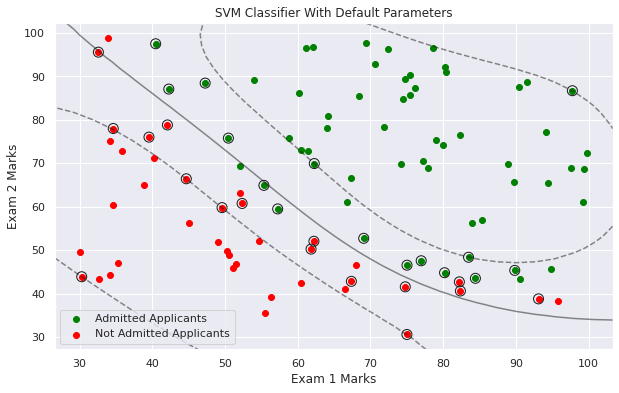

In [ ]:
#Lets create feature matrix X and label vector y
df = pd.read_csv('https://raw.githubusercontent.com/satishgunjal/datasets/master/admission_basedon_exam_scores.csv')

# X = df[['Ca', 'Na']]
# y = df['classes']
# df = df[:146]
X = df[['Exam 1 marks', 'Exam 2 marks']]
y = df['Admission status']

print('Shape of X= ', X.shape)
print('Shape of y= ', y.shape)

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state= 1)

print('X_train dimension= ', X_train.shape)
print('X_test dimension= ', X_test.shape)
print('y_train dimension= ', y_train.shape)
print('y_train dimension= ', y_test.shape)

clf = svm.SVC()
clf.fit(X_train, y_train)
print('Model score using default parameters is = ', clf.score(X_test, y_test))

def plot_support_vector(classifier):
    """
    To plot decsion boundary and margin. Code taken from Sklearn documentation.

    I/P
    ----------
    classifier : SVC object for each type of kernel

    O/P
    -------
    Plot
    
    """
    clf =classifier
    # plot the decision function
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1],30)
    yy = np.linspace(ylim[0], ylim[1],30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = clf.decision_function(xy).reshape(XX.shape)

    # plot decision boundary and margins
    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    # plot support vectors
    ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
               linewidth=1, facecolors='none', edgecolors='k') 
    print(clf.n_support_)

plot_data(title = 'SVM Classifier With Default Parameters')
plot_support_vector(clf)  

In [ ]:
def svm_params(X_train, y_train, X_test, y_test):
    """
    Finds the best choice of Regularization parameter (C) and gamma for given choice of kernel and returns the SVC object for each type of kernel

    I/P
    ----------
    X_train : ndarray
        Training samples
    y_train : ndarray
        Labels for training set
    X_test : ndarray
        Test data samples
    y_test : ndarray
        Labels for test set.

    O/P
    -------
    classifiers : SVC object for each type of kernel
    
    """
    C_values = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 40]
    gamma_values = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 40]
    kernel_types = ['linear', 'poly', 'rbf']
    classifiers = {}
    max_score = -1
    C_final = -1
    gamma_final = -1
    for kernel in kernel_types:                    
        for C in C_values:
            for gamma in gamma_values:
                clf = svm.SVC(C=C, kernel= kernel, gamma=gamma)
                clf.fit(X_train, y_train)
                score = clf.score(X_test, y_test)
                #print('C = %s, gamma= %s, score= %s' %(C, gamma, score))
                if score > max_score:
                    max_score = score
                    C_final = C
                    gamma_final = gamma
                    classifiers[kernel] = clf        
        print('kernel = %s, C = %s, gamma = %s, score = %s' %(kernel, C_final, gamma_final, max_score))
    return classifiers

classifiers = svm_params(X_train, y_train, X_test, y_test)



kernel = linear, C = 0.01, gamma = 0.01, score = 0.85
kernel = poly, C = 0.01, gamma = 0.01, score = 0.95
kernel = rbf, C = 1, gamma = 0.03, score = 1.0


[9 9]


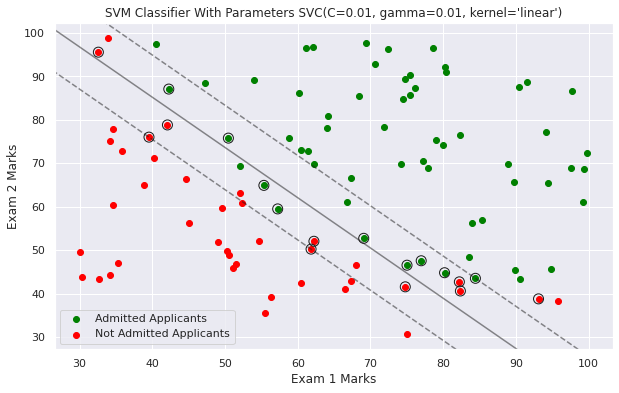

In [ ]:
plot_data(title = 'SVM Classifier With Parameters ' + str(classifiers['linear']))
plot_support_vector(classifiers['linear'])

Number of support vectors for each class:  [27 39]


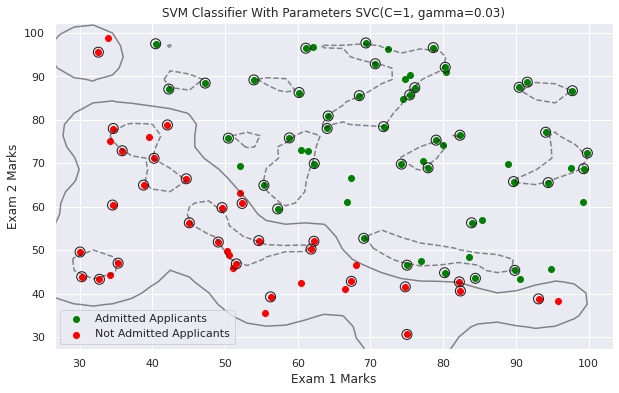

In [ ]:
plot_data(title = 'SVM Classifier With Parameters ' + str(classifiers['rbf']))
plot_support_vector(classifiers['rbf'])

Number of support vectors for each class:  [3 1]


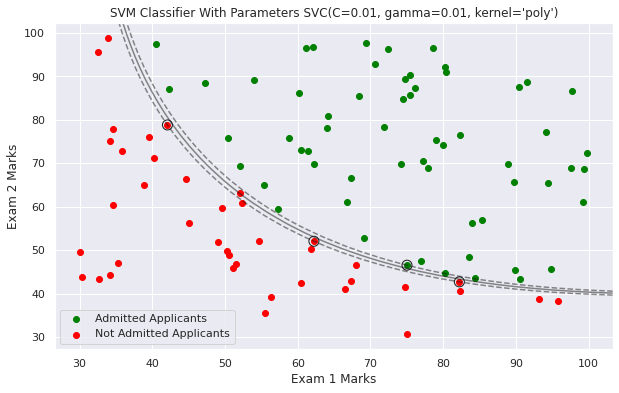

In [ ]:
plot_data(title = 'SVM Classifier With Parameters ' + str(classifiers['poly']))
plot_support_vector(classifiers['poly'])